In [1]:
import os
import shutil
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications as K_models
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

from sklearn.metrics import f1_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def paths(dir):
    file_paths = []
    labels = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        files = os.listdir(folder_path)
        for file in files:
            file_path = os.path.join(folder_path, file)
            file_paths.append(file_path)
            labels.append(folder)
    return file_paths, labels

def paths_to_df(filepaths, labels):
    return pd.DataFrame({'filepath': filepaths, 'labels': labels})

def create_dfs(train_folder, test_folder, valid_folder):
    # train
    train_f_paths, train_labels = paths(train_folder)
    train_df = paths_to_df(train_f_paths, train_labels)
    
    # test
    test_f_paths, test_labels = paths(test_folder)
    test_df = paths_to_df(test_f_paths, test_labels)

    # validation
    valid_f_paths, valid_labels = paths(valid_folder)
    valid_df = paths_to_df(valid_f_paths, valid_labels)

    return train_df, test_df, valid_df
    

In [3]:
train_dir = '../input/chest-ctscan-images/Data/train'
test_dir = '../input/chest-ctscan-images/Data/valid'
valid_dir = '../input/chest-ctscan-images/Data/test'

train_df, test_df, valid_df = create_dfs(train_dir, test_dir, valid_dir)

In [4]:
train_df

,filepath,labels
0,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
1,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
2,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
3,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
4,../input/chest-ctscan-images/Data/train/squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
...,...,...
608,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
609,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
610,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
611,../input/chest-ctscan-images/Data/train/adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [5]:
print(f"train size: {train_df.size}, test size: {test_df.size}, validation size: {valid_df.size}")
print(f"number of classes for train: {train_df.labels.nunique()}, for test: {test_df.labels.nunique()} and for validation: {valid_df.labels.nunique()}")

train size: 1226, test size: 144, validation size: 630
number of classes for train: 4, for test: 4 and for validation: 4


## Renaming the Labels

In [6]:
train_df.labels = train_df.labels.replace({'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous_cell_carcinoma',
                                           'normal': 'Normal',
                                           'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large_cell_carcinoma',
                                           'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma'})
test_df.labels = test_df.labels.replace({'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous_cell_carcinoma',
                                           'normal': 'Normal',
                                           'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large_cell_carcinoma',
                                           'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma'})
valid_df.labels = valid_df.labels.replace({'squamous.cell.carcinoma': 'Squamous_cell_carcinoma',
                                           'normal': 'Normal',
                                           'large.cell.carcinoma': 'Large_cell_carcinoma',
                                           'adenocarcinoma': 'Adenocarcinoma'})

# Plotting the Classes

In [7]:
# Getting the colors for the plots
blue = sns.color_palette('crest')[3]
red  = sns.color_palette('flare')[2]

# Creating a plot function for the 4 classes
def plot_counts(df,name):
    plt.figure(figsize=(8,6))
    plot = sns.countplot(
                        data=df,
                        x = 'labels',
                        palette = {
                            "Normal": red,
                            "Squamous_cell_carcinoma": blue,
                            "Large_cell_carcinoma": blue,
                            "Adenocarcinoma": blue
                        }
    )

    plt.title(f'Sample counts in {name} df')
    plt.xlabel('Cell Type')
    plt.ylabel('Samples')
    plot.bar_label(plot.containers[0])
    plt.show()

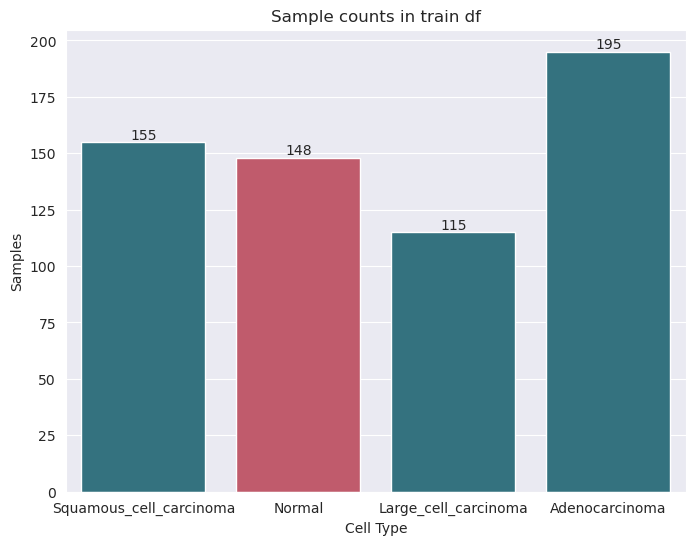

In [8]:
plot_counts(train_df,'train')

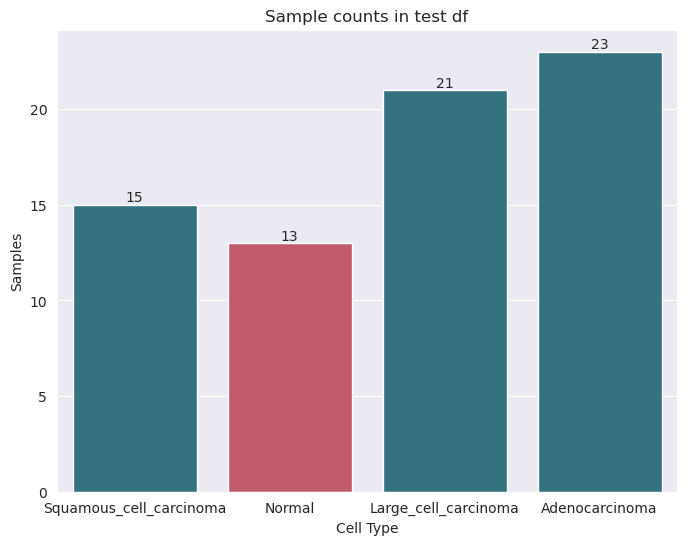

In [9]:
plot_counts(test_df,'test')

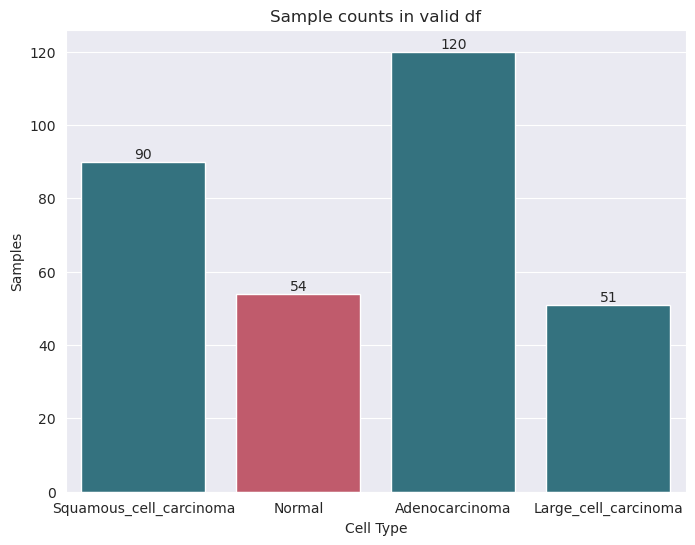

In [10]:
plot_counts(valid_df, 'valid')

## Balancing the 4 classes

In [11]:
def augment(df, working_dir, n = 200):
    df = df.copy()
    print(f"The initial size of the dataframe is {len(df)}")
    # Create a directory to store the augmented images
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.exists(aug_dir):
        shutil.rmtree(aug_dir) # delete the directory if it already exists
    os.mkdir(aug_dir)
    # Create directories for each label
    for label in df.labels.unique():
        path = os.path.join(aug_dir, label)
        os.mkdir(path)
    
    # Create the augmented images
    total = 0
    img_gen = ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=.2,
                                 height_shift_range=.2,
                                 zoom_range=.2)
    
    groups = df.groupby('labels')
    for label in df.labels.unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count # number of augmented images
            dir_to_store = os.path.join(aug_dir, label)
            msg=f"{' ':40s} for class {label:^30s} creating {str(delta):^5s} augmented images"
            print(msg, '\r', end='')
            aug_gen = img_gen.flow_from_dataframe(group,
                                              x_col       = 'filepath',
                                              y_col       = None,
                                              target_size = (300,440),
                                              class_mode  = None,
                                              batch_size  = 1,
                                              shuffle     = False,
                                              save_to_dir = dir_to_store,
                                              save_prefix = 'aug_',
                                              color_mode  = 'rgb',
                                              save_format = 'jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
            
    print(f"Total augmented images: {total}")
    # Create the augmented DataFrame
    aug_fpaths = []
    aug_labels = []
    classlist = sorted(os.listdir(aug_dir))
    for class_ in classlist:
        classpath = os.path.join(aug_dir, class_)     
        filelist = sorted(os.listdir(classpath))    
        for file in filelist:
            fpath=os.path.join(classpath,file)
            aug_fpaths.append(fpath)
            aug_labels.append(class_)
    aug_df = pd.DataFrame({'filepath': aug_fpaths, 'labels': aug_labels})
    # Join the two DataFrames
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print(f"The length of the augmented dataframe is {len(df)}")
    return df
    
w_dir = r'./'
train_df = augment(train_df, w_dir)

The initial size of the dataframe is 613
Found 155 validated image filenames.
Found 148 validated image filenames.
Found 115 validated image filenames.
Found 195 validated image filenames.
Total augmented images: 187
The length of the augmented dataframe is 800


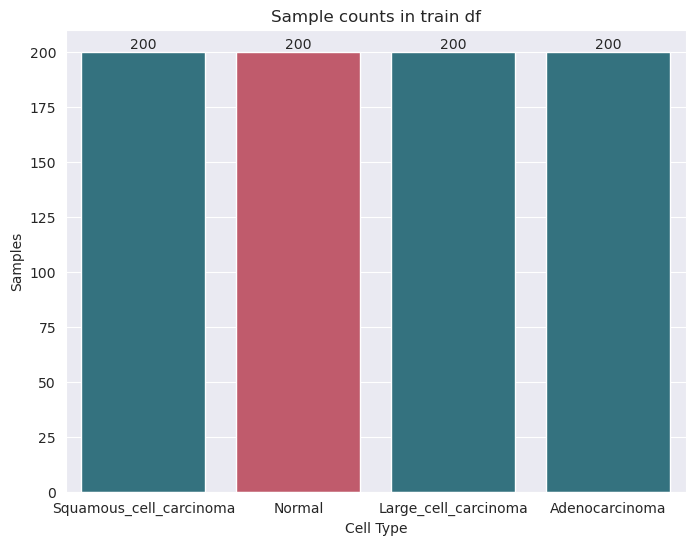

In [12]:
plot_counts(train_df, 'train')

The 4 classes of the train dataset are now balanced!

## Make Image Generators

In [13]:
def make_gens(train_df, test_df, valid_df, batch_size):
    # Initiate the ImageDataGenerators
    train_generator  = ImageDataGenerator(horizontal_flip=True) # Generator for train data
    test_n_valid_gen = ImageDataGenerator()                     # Generator for validation and test data

    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    # Train Generator 
    train_gen = train_generator.flow_from_dataframe(train_df,
                                                    x_col       = 'filepath',
                                                    y_col       = 'labels',
                                                    target_size = (300,440),
                                                    class_mode  = 'categorical',
                                                    color_mode  = 'rgb',
                                                    shuffle     = True,
                                                    batch_size  = batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    # Valid Generator
    valid_gen=test_n_valid_gen.flow_from_dataframe(valid_df, 
                                                   x_col       = 'filepath',
                                                   y_col       = 'labels',
                                                   target_size = (300,440),
                                                   class_mode  = 'categorical',
                                                   color_mode  = 'rgb',
                                                   shuffle     = False,
                                                   batch_size  = batch_size)
    
    
    # for the test_gen we want to calculate the batch size and test steps
    # such that batch_size X test_steps = number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    
    # Test batch size
    length=len(test_df)
    test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps = int(length/test_batch_size)    
    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    # Test Generator
    test_gen = test_n_valid_gen.flow_from_dataframe(test_df,
                                                    x_col       = 'filepath',
                                                    y_col       = 'labels',
                                                    target_size = (300,440),
                                                    class_mode  = 'categorical',
                                                    color_mode  = 'rgb',
                                                    shuffle     = False,
                                                    batch_size  = test_batch_size)
    
    # from the generator we can get information we will need later
    classes = list(train_gen.class_indices.keys())
    class_indices = list(train_gen.class_indices.values())
    class_count = len(classes)
    labels = test_gen.labels
    
    print ( f"test batch size: {test_batch_size}, test steps: {test_steps}, number of classes : {class_count}")
    
    return train_gen, test_gen, valid_gen, test_steps

train_gen, test_gen, valid_gen, test_steps = make_gens(train_df, test_df, valid_df, batch_size=20)

Found 800 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
test batch size: 72, test steps: 1, number of classes : 4


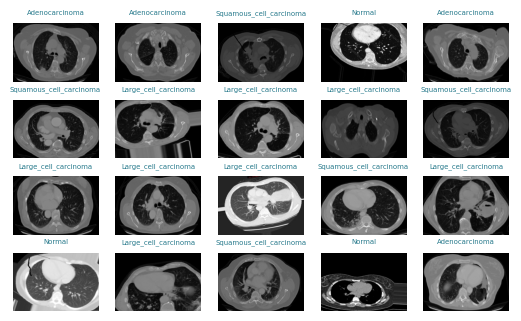

In [14]:
# A function to visualize the samples
def samples(generator):
    cls_ind = generator.class_indices
    classes = list(cls_ind.keys()) # convert to list so it can be subscriptable
    imgs, labels = next(generator) # get a sample batch
    l = len(labels)

    for i in range(l):
        plt.subplot(5, 5, i+1)
        img = imgs[i] / 255
        plt.imshow(img)
        idx = np.argmax(labels[i])
        cls_name = classes[idx]
        plt.title(cls_name, fontsize = 5, color=blue)
        plt.axis(False)
    plt.show()

samples(train_gen)

## Making the models

In [15]:
# Choosing the models architecture
efficientnet = K_models.efficientnet_v2
resnet       = K_models.resnet_v2
vgg19        = K_models.vgg19

In [16]:
def make_model(a, model):  
    img_shape=(300, 400, 3)
    model = model(include_top = False,        # include the fully-connected layer at the top of the network.
                  weights     = 'imagenet',   # take the weights from the imagenet
                  input_shape = img_shape,    
                  pooling     = 'max')

    model.trainable=True
    # Layers
    x = model.output
    
    x = BatchNormalization(axis     = -1,
                           momentum = 0.99,
                           epsilon  = 0.001)(x)
    
    x = Dense(256,
              kernel_regularizer     = regularizers.l2(l = 0.016),
              activity_regularizer   = regularizers.l1(0.006),
              bias_regularizer       = regularizers.l1(0.006),
              activation             = 'relu')(x)
    
    x = Dropout(rate = .4,
                seed = 123)(x)
    
    output = Dense(4,                     # 4 classes
                   activation = 'softmax' # softmax activation for multiclass classification
                   )(x)
    
    model = Model(inputs=model.input, outputs=output)
    model.compile(Adamax(learning_rate = a),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 
    return model

a = .001 # the learning rate

In [17]:
# Initiating the models
eff_model = make_model(a, model = efficientnet.EfficientNetV2B3) 
resnet50_model = make_model(a, model = resnet.ResNet50V2)
vgg19_model = make_model(a, model = vgg19.VGG19)

80134624/80134624 [==============================] - 0s 0us/step


In [18]:
# Fit function for the models
def fit_the_model(model, train_gen=train_gen):
    history_obj = model.fit(x                = train_gen,
                            epochs           = 40,
                            initial_epoch    = 0,
                            verbose          = 1,
                            validation_data  = valid_gen,
                            validation_steps = None,
                            shuffle          = False,
                            )
    return history_obj

## EfficientNetV3

In [19]:
eff_history = fit_the_model(eff_model)

Epoch 1/40


2023-06-04 11:30:51.318196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 110s 809ms/step - loss: 8.4075 - accuracy: 0.6350 - val_loss: 8.5600 - val_accuracy: 0.7016
Epoch 2/40
40/40 [==============================] - 26s 651ms/step - loss: 7.1085 - accuracy: 0.8250 - val_loss: 6.9832 - val_accuracy: 0.7746
Epoch 3/40
40/40 [==============================] - 26s 653ms/step - loss: 6.1934 - accuracy: 0.9062 - val_loss: 6.0224 - val_accuracy: 0.8762
Epoch 4/40
40/40 [==============================] - 27s 674ms/step - loss: 5.5420 - accuracy: 0.9500 - val_loss: 5.4404 - val_accuracy: 0.8952
Epoch 5/40
40/40 [==============================] - 26s 661ms/step - loss: 5.0174 - accuracy: 0.9588 - val_loss: 4.9638 - val_accuracy: 0.8984
Epoch 6/40
40/40 [==============================] - 27s 666ms/step - loss: 4.5250 - accuracy: 0.9787 - val_loss: 4.4894 - val_accuracy: 0.9302
Epoch 7/40
40/40 [==============================] - 27s 669ms/step - loss: 4.1339 - accuracy: 0.9762 - val_loss: 4.1172 - val_accuracy: 0.9111
Epoch 8/4

## ResNet50

In [20]:
resnet_history = fit_the_model(resnet50_model)

Epoch 1/40
40/40 [==============================] - 60s 638ms/step - loss: 8.8539 - accuracy: 0.6225 - val_loss: 25.6302 - val_accuracy: 0.1714
Epoch 2/40
40/40 [==============================] - 22s 551ms/step - loss: 7.7778 - accuracy: 0.7362 - val_loss: 16.8018 - val_accuracy: 0.3079
Epoch 3/40
40/40 [==============================] - 22s 555ms/step - loss: 6.8367 - accuracy: 0.8462 - val_loss: 9.7800 - val_accuracy: 0.5524
Epoch 4/40
40/40 [==============================] - 22s 560ms/step - loss: 6.1065 - accuracy: 0.9237 - val_loss: 9.3471 - val_accuracy: 0.4921
Epoch 5/40
40/40 [==============================] - 23s 563ms/step - loss: 5.5083 - accuracy: 0.9525 - val_loss: 6.6059 - val_accuracy: 0.6762
Epoch 6/40
40/40 [==============================] - 23s 564ms/step - loss: 4.9808 - accuracy: 0.9850 - val_loss: 5.4971 - val_accuracy: 0.7460
Epoch 7/40
40/40 [==============================] - 23s 566ms/step - loss: 4.5526 - accuracy: 0.9812 - val_loss: 4.8744 - val_accuracy: 0.82

## VGG19

In [21]:
vgg19_history = fit_the_model(vgg19_model)

Epoch 1/40
40/40 [==============================] - 75s 1s/step - loss: 6.3535 - accuracy: 0.5100 - val_loss: 104.4692 - val_accuracy: 0.1714
Epoch 2/40
40/40 [==============================] - 46s 1s/step - loss: 5.2410 - accuracy: 0.5525 - val_loss: 9.4964 - val_accuracy: 0.1714
Epoch 3/40
40/40 [==============================] - 45s 1s/step - loss: 4.6004 - accuracy: 0.5587 - val_loss: 7.1396 - val_accuracy: 0.1968
Epoch 4/40
40/40 [==============================] - 46s 1s/step - loss: 4.1000 - accuracy: 0.5975 - val_loss: 5.2248 - val_accuracy: 0.2921
Epoch 5/40
40/40 [==============================] - 45s 1s/step - loss: 3.7103 - accuracy: 0.6162 - val_loss: 4.0430 - val_accuracy: 0.3651
Epoch 6/40
40/40 [==============================] - 45s 1s/step - loss: 3.3543 - accuracy: 0.6388 - val_loss: 3.5296 - val_accuracy: 0.3651
Epoch 7/40
40/40 [==============================] - 45s 1s/step - loss: 3.1007 - accuracy: 0.6350 - val_loss: 3.3356 - val_accuracy: 0.3619
Epoch 8/40
40/40 [

## Loss and Accuracy

In [22]:
# Plot function for loss and accuracy
def plot_history(history_obj, name):
    loss_history = history_obj.history['loss']
    val_loss_hist = history_obj.history['val_loss']
    epochs_num = [i+1 for i in range(0, len(history_obj.history['loss']))]
    tr_min_idx = np.argmin(loss_history)
    val_min_idx = np.argmin(val_loss_hist)
    print(f"The epoch {tr_min_idx} had the minimum loss value of {loss_history[tr_min_idx]} for the training dataset\n")
    print(f"The epoch {val_min_idx} had the minimum loss value of {val_loss_hist[val_min_idx]} for the validation dataset\n")
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (12,5))
    ax[0].plot(loss_history, label='train_loss')
    ax[0].plot(val_loss_hist, label='val_loss')
    ax[0].set_title('Train and validation loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    tr_acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    ax[1].plot(tr_acc, label='train_accuracy')
    ax[1].plot(val_acc, label='val_accuracy')
    ax[1].set_title('Train and validation accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()


The epoch 39 had the minimum loss value of 0.24136531352996826 for the training dataset

The epoch 39 had the minimum loss value of 0.3882516026496887 for the validation dataset



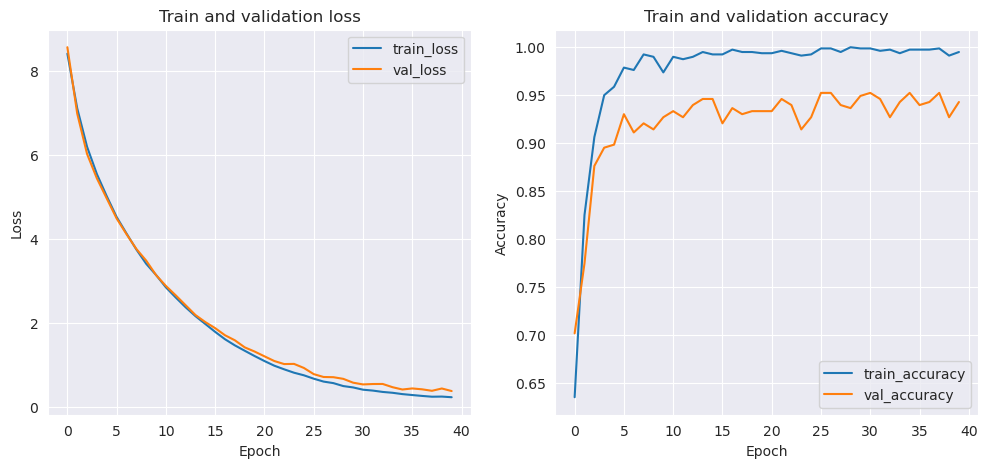

In [23]:
plot_history(eff_history, 'EfficientNetV3')

The epoch 39 had the minimum loss value of 0.2747543156147003 for the training dataset

The epoch 39 had the minimum loss value of 0.6168788075447083 for the validation dataset



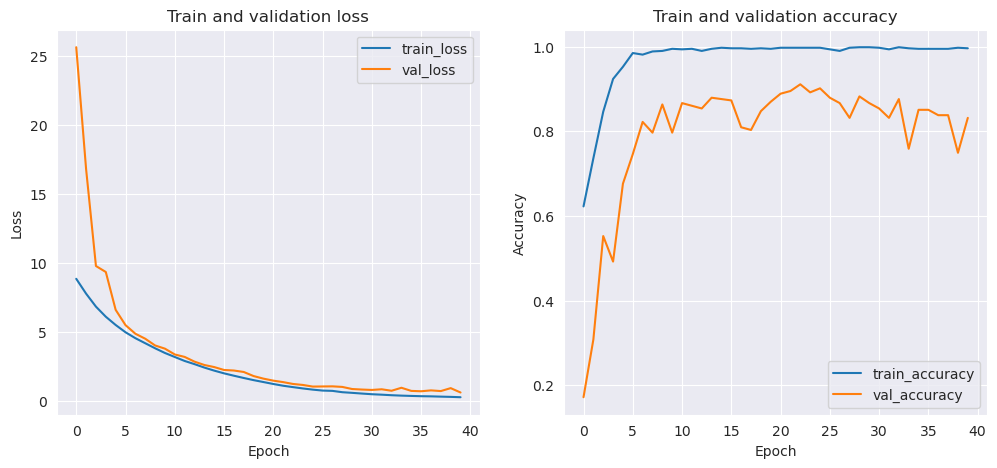

In [24]:
plot_history(resnet_history, 'resnet50')

The epoch 38 had the minimum loss value of 0.5897806882858276 for the training dataset

The epoch 33 had the minimum loss value of 1.4603558778762817 for the validation dataset



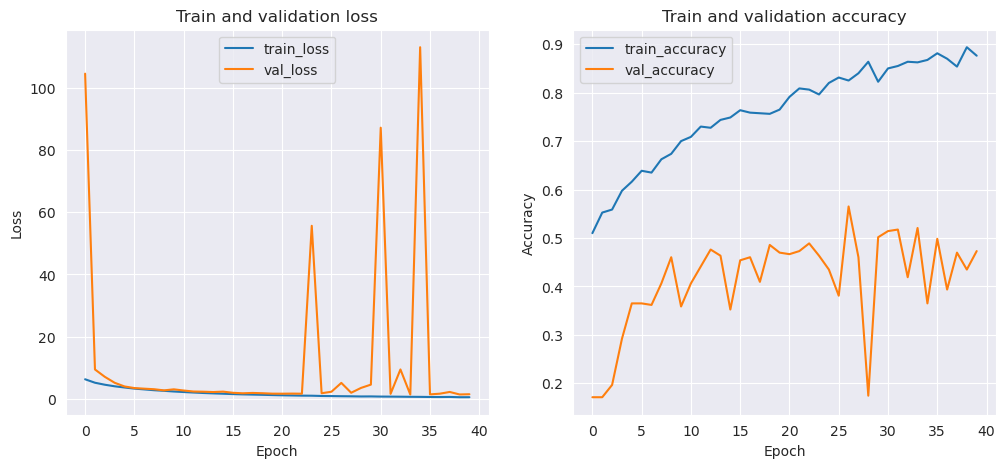

In [25]:
plot_history(vgg19_history,'vgg19')

## Precision, Recall and F1 score

In [26]:
# Function for predicting and giving metrics
def predict(test_gen,model):    
    y_pred          = []
    error_list      = []
    error_pred_list = []
    y_true          = test_gen.labels
    classes         = list(test_gen.class_indices.keys())
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index:     # a misclassification has occurred                                           
            errors += 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc = (1 - errors / tests) * 100
    msg = f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}"
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    cm = confusion_matrix(ytrue, ypred )
    
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm,
                annot = True,
                vmin  = 0,
                fmt   = 'g',
                cmap  = 'Blues',
                cbar  = False)
    
    plt.xticks(np.arange(4) + .5, classes, rotation = 90)
    plt.yticks(np.arange(4) + .5, classes, rotation = 0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    clr = classification_report(y_true, y_pred, target_names = classes, digits= 4) # create classification report
    print(f"Classification Report:\n----------------------\n {clr}")
    return errors, tests, error_list, error_pred_list, f1score

1/1 [==============================] - 8s 8s/step


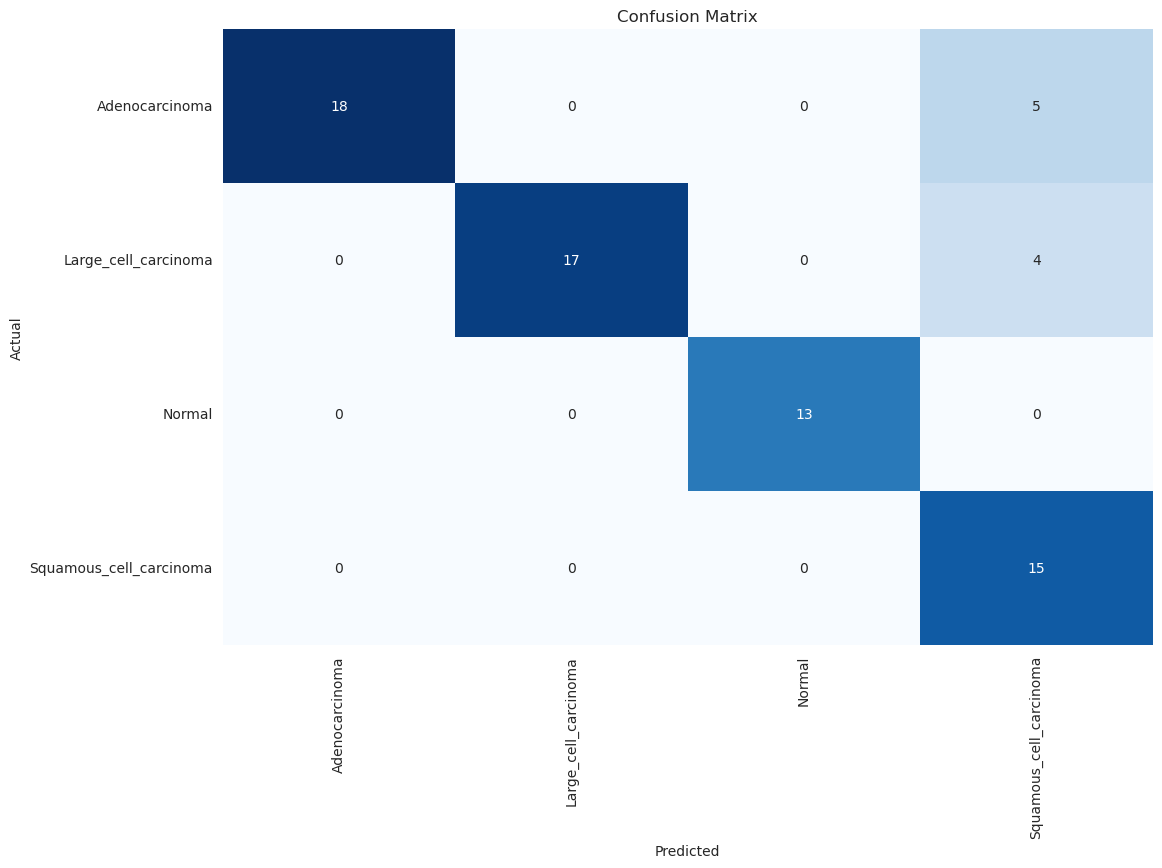

Classification Report:
----------------------
                          precision    recall  f1-score   support

         Adenocarcinoma     1.0000    0.7826    0.8780        23
   Large_cell_carcinoma     1.0000    0.8095    0.8947        21
                 Normal     1.0000    1.0000    1.0000        13
Squamous_cell_carcinoma     0.6250    1.0000    0.7692        15

               accuracy                         0.8750        72
              macro avg     0.9062    0.8980    0.8855        72
           weighted avg     0.9219    0.8750    0.8823        72



In [27]:
eff_errors, eff_tests, eff_error_list, eff_error_pred_list, eff_f1score = predict(test_gen, eff_model)

1/1 [==============================] - 9s 9s/step


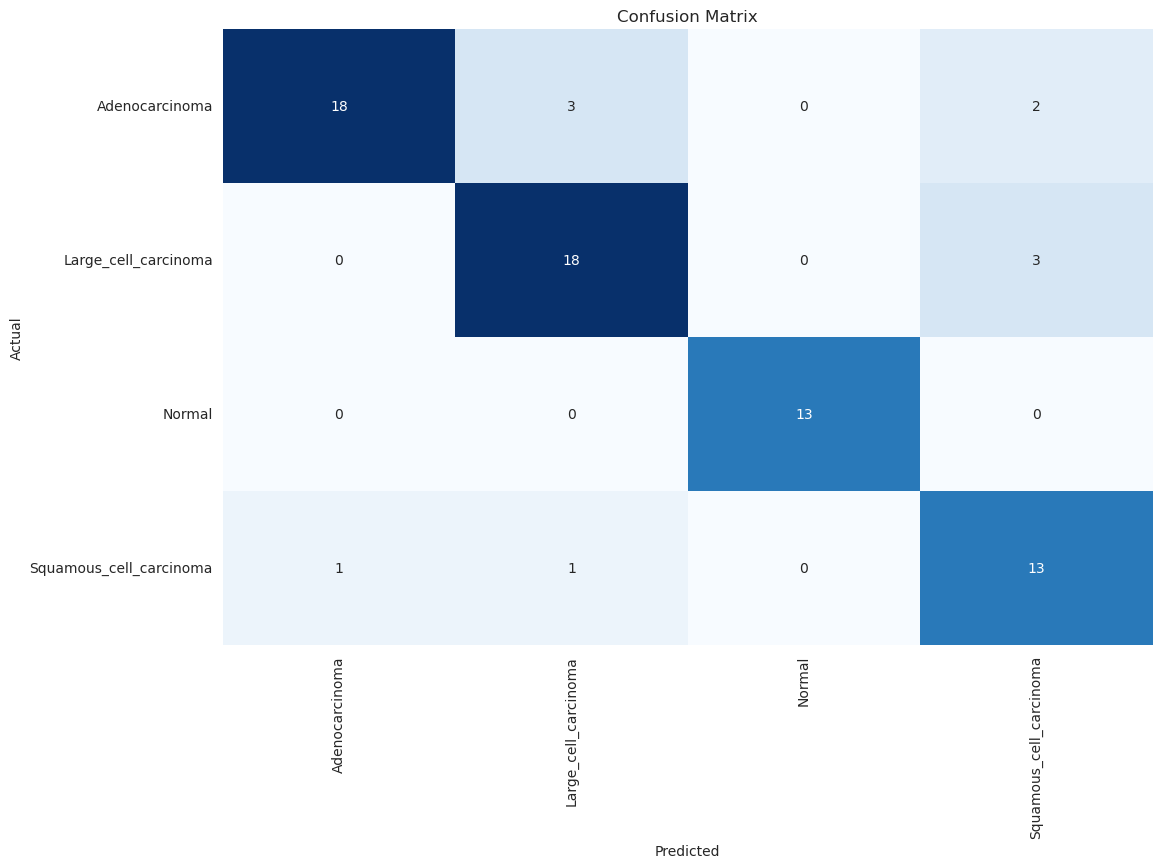

Classification Report:
----------------------
                          precision    recall  f1-score   support

         Adenocarcinoma     0.9474    0.7826    0.8571        23
   Large_cell_carcinoma     0.8182    0.8571    0.8372        21
                 Normal     1.0000    1.0000    1.0000        13
Squamous_cell_carcinoma     0.7222    0.8667    0.7879        15

               accuracy                         0.8611        72
              macro avg     0.8719    0.8766    0.8706        72
           weighted avg     0.8723    0.8611    0.8627        72



In [28]:
res_errors, res_tests, res_error_list, res_error_pred_list, res_f1score = predict(test_gen, resnet50_model)

1/1 [==============================] - 22s 22s/step


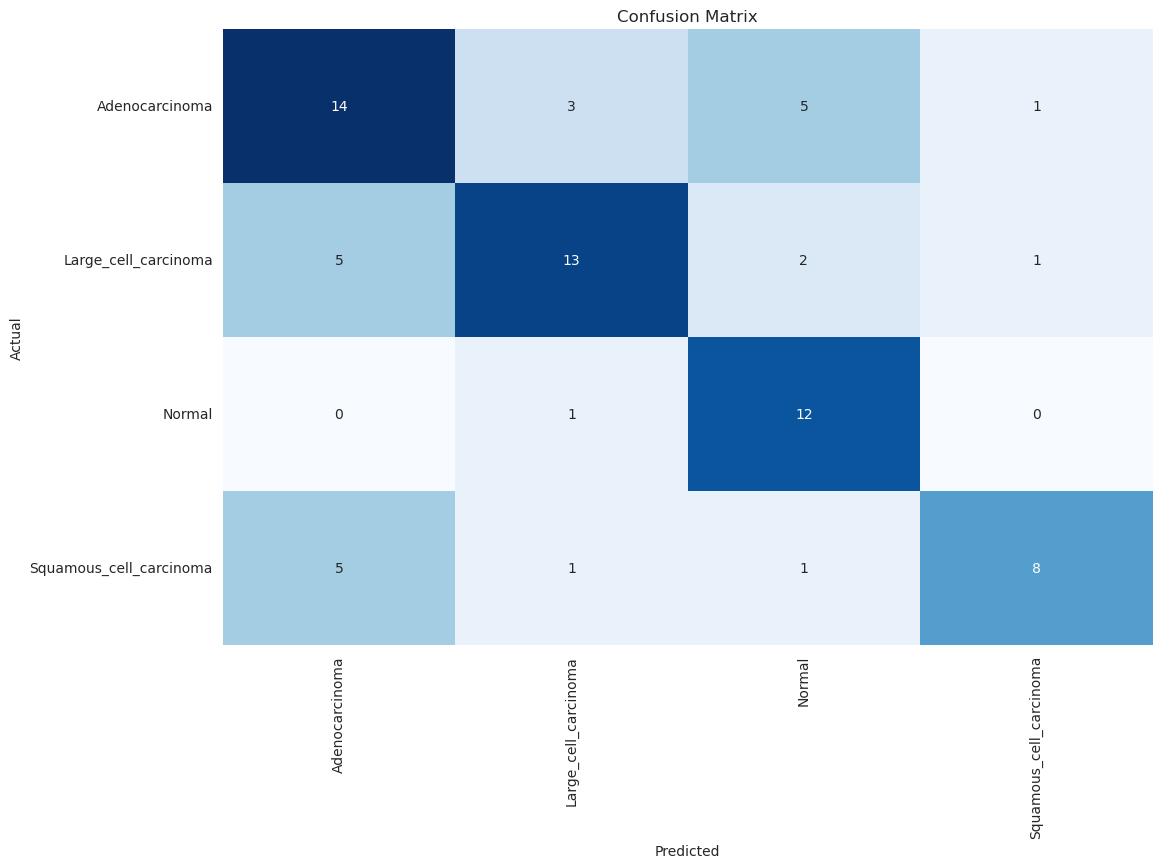

Classification Report:
----------------------
                          precision    recall  f1-score   support

         Adenocarcinoma     0.5833    0.6087    0.5957        23
   Large_cell_carcinoma     0.7222    0.6190    0.6667        21
                 Normal     0.6000    0.9231    0.7273        13
Squamous_cell_carcinoma     0.8000    0.5333    0.6400        15

               accuracy                         0.6528        72
              macro avg     0.6764    0.6710    0.6574        72
           weighted avg     0.6720    0.6528    0.6494        72



In [29]:
vgg_errors, vgg_tests, vgg_error_list, vgg_error_pred_list, vgg_f1score = predict(test_gen, vgg19_model)

In [30]:
print(f"F1 score - EfficientNet: {round(eff_f1score, 2)}, ResNet50: {round(res_f1score, 2)}, VGG19: {round(vgg_f1score, 2)}")
print("EfficientNet has the best accuracy based on the F1 score metric")

F1 score - EfficientNet: 88.23, ResNet50: 86.27, VGG19: 64.94
EfficientNet has the best accuracy based on the F1 score metric


# Misclassified predictions

In [31]:
# Function to print the error lists
def print_error_lists(error_list, error_pred_list):
    print(f"{'Truth':^45s} {'Predicted':^45s}")
    for i,j in enumerate(error_list):
        print(f"{error_list[i].split('/')[5]:^45s} {error_pred_list[i]:^45s}")

In [32]:
print_error_lists(eff_error_list, eff_error_pred_list)    

                    Truth                                       Predicted                  
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           


In [33]:
print_error_lists(res_error_list, res_error_pred_list)    

                    Truth                                       Predicted                  
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa             Large_cell_carcinoma             
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_carcinoma           
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib               Large_cell_carcinoma             
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib               Large_cell_carcinoma             
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib               Large_cell_carcinoma             
 adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib              Squamous_cell_car

In [34]:
print_error_lists(vgg_error_list, vgg_error_pred_list) 

                    Truth                                       Predicted                  
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                    Normal                    
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa                Adenocarcinoma                
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa             Large_cell_carcinoma             
                   normal                                 Large_cell_carcinoma             
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa            Squamous_cell_carcinoma           
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa              

In [35]:
def errors_plot(eff_error,res_error, vgg_error):
    df = pd.DataFrame({'EfficientNet': len(eff_error), 'ResNet50': len(res_error), 'VGG19': len(vgg_error)},index=[0,1,2])
    plot = sns.barplot(df,
                       palette={
                            'EfficientNet': red,
                            'ResNet50': blue,
                            'VGG19': blue
                       })
    plt.title('Misclassified images')
    plt.xlabel('Models')
    plt.ylabel('Number of images')
    plot.bar_label(plot.containers[0])

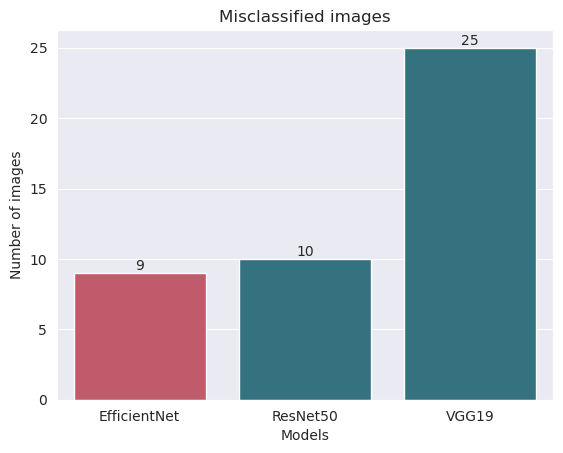

In [36]:
errors_plot(eff_error_list, res_error_list, vgg_error_list)

## Saving the models

In [37]:
def save_the_model(model, name):
    path = os.path.join(w_dir, name)      # create the path 
    if os.path.exists(path):              # if the path already exists
        shutil.rmtree(path)               # delete the directory
    os.mkdir(path)                        # make the folder
    fname=f"ct_chest_{name}.h5"           # create a name for the model
    model.save(os.path.join(path, fname)) # save the model

def load_the_model(path, name):
    model = tf.keras.models.load_model(os.path.join(path, name)) # load the model
    return model

In [38]:
save_the_model(eff_model, 'efficientNetV3')
save_the_model(resnet50_model, 'resnet50')
save_the_model(vgg19_model, 'vgg19')